In [1]:

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


In [2]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

<ipython-input-2-2c3453f6a0a6>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(faces.target.shape, dtype=np.bool)


(500, 128, 128, 3)

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=10)

Epoch 1/20
40/40 [==============================] - 5s 17ms/step - loss: 29.7543 - accuracy: 0.2025 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/20
40/40 [==============================] - 0s 11ms/step - loss: 1.6100 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6101 - accuracy: 0.1700 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6098 - accuracy: 0.1675 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 5/20
40/40 [==============================] - 1s 15ms/step - loss: 1.6100 - accuracy: 0.1625 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 6/20
40/40 [==============================] - 1s 16ms/step - loss: 1.6099 - accuracy: 0.1750 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 7/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6099 - accuracy: 0.1350 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 8/20
4

In [5]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
40/40 [==============================] - 3s 79ms/step - loss: 1.0508 - accuracy: 0.5775 - val_loss: 1.3149 - val_accuracy: 0.4600
Epoch 2/20
40/40 [==============================] - 3s 74ms/step - loss: 1.1151 - accuracy: 0.5200 - val_loss: 1.0889 - val_accuracy: 0.6200
Epoch 3/20
40/40 [==============================] - 3s 71ms/step - loss: 1.0575 - accuracy: 0.5850 - val_loss: 1.2038 - val_accuracy: 0.4700
Epoch 4/20
40/40 [==============================] - 3s 78ms/step - loss: 1.0548 - accuracy: 0.5725 - val_loss: 1.0969 - val_accuracy: 0.5600
Epoch 5/20
40/40 [==============================] - 3s 77ms/step - loss: 1.0314 - accuracy: 0.5875 - val_loss: 1.0534 - val_accuracy: 0.6000
Epoch 6/20
40/40 [==============================] - 3s 78ms/step - loss: 1.2546 - accuracy: 0.4925 - val_loss: 1.0283 - val_accuracy: 0.5900
Epoch 7/20
40/40 [==============================] - 3s 78ms/step - loss: 1.0568 - accuracy: 0.6100 - val_loss: 0.9661 - val_accuracy: 0.7100
Epoch 8/20
40

[]

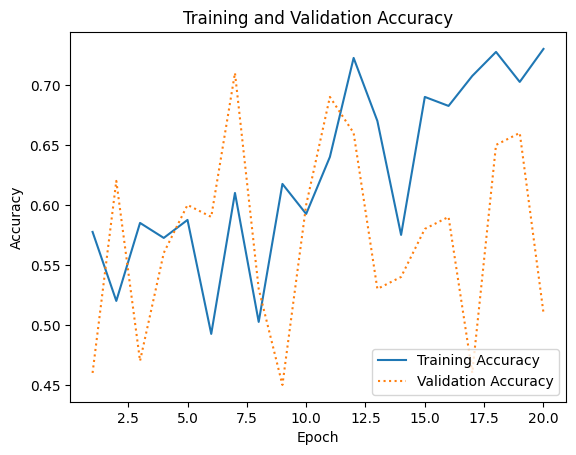

In [9]:
import matplotlib.pyplot as plt
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()